### Setup your environnement variables

In [1]:
import os

os.environ["OPENAI_API_KEY"] = "YOUR API KEY"
os.environ["UIFORM_API_KEY"] = "YOUR API KEY" # go to https://uiform.com to create your API Key

In [2]:
from dotenv import load_dotenv
assert load_dotenv("../.env.local", override=True) # Load environment variables from a .env file

# Get started

In [3]:
from uiform import UiForm
from uiform._utils.json_schema import filter_reasoning_fields_json
uiclient = UiForm()
models_list = uiclient.models.list()

/home/vscode/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Example 1 - Analyze informations from a document

#### Option A - You use our preprocess endpoint and openAI client

In [4]:
import json
from uiform import UiForm, Schema
from openai import OpenAI

with open("freight/schema.json", "r") as f:
    json_schema = json.load(f)


uiclient = UiForm()
doc_msg = uiclient.documents.create_messages(
    document = "freight/booking_confirmation.jpg",
)

schema_obj = Schema(
    json_schema = json_schema
)



In [ ]:

# Now you can use your favorite model to analyze your document
client = OpenAI()
completion = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=schema_obj.openai_messages + doc_msg.openai_messages,
    response_format={
        "type": "json_schema",
        "json_schema": {
            "name": schema_obj.id,
            "schema": schema_obj.inference_json_schema,
            "strict": True
        }
    }
)
print(completion.choices[0].message.content)

In [ ]:
# Validate the response against the original schema if you want to remove the reasoning fields
assert completion.choices[0].message.content is not None
extraction = schema_obj.pydantic_model.model_validate(
     filter_reasoning_fields_json(completion.choices[0].message.content)
)
extraction.model_dump()

In [ ]:
## If you want to log the extraction (keep it in our database)
# Limitation: we don't get the likelihoods
# For now one might send the messages in UiForm-compatible format.
uiclient.documents.extractions.log(
    document = "freight/booking_confirmation.jpg",
    messages = schema_obj.messages + doc_msg.messages,
    completion = completion,
    json_schema = json_schema,
    model = "gpt-4o-mini",
    temperature = 0,
)

In [ ]:
# You can use the messages from different providers (but you cannot mix them)
out_log_openai = uiclient.documents.extractions.log(
    document = "freight/booking_confirmation.jpg",
    openai_messages = schema_obj.openai_messages + doc_msg.openai_messages,
    completion = completion,
    json_schema = json_schema,
    model = "gpt-4o-mini",
    temperature = 0,
)
print(out_log_openai)

out_log_anthropic = uiclient.documents.extractions.log(
    document = "freight/booking_confirmation.jpg",
    anthropic_messages = schema_obj.anthropic_messages + doc_msg.anthropic_messages,
    anthropic_system_prompt = schema_obj.anthropic_system_prompt,
    completion = completion,
    json_schema = json_schema,
    model = "gpt-4o-mini",
    temperature = 0,
)
print(out_log_anthropic)





#### Option B - Using UiForm `extract` endpoint

In [ ]:
import json
from uiform.client import UiForm

uiclient = UiForm()
completion = uiclient.documents.extractions.parse(
    json_schema = "freight/schema.json",
    document = "freight/booking_confirmation.jpg",
    model="gpt-4o-mini",
    temperature=0,
)

filter_reasoning_fields_json(completion.choices[0].message.content)

# For streaming:
# from IPython.display import clear_output, display

# with uiclient.documents.extractions.stream(
#     json_schema = "freight/schema.json",
#     document = "freight/booking_confirmation.jpg",
#     model="gpt-4o-mini",
#     temperature=0,
# ) as stream:
#     for chunk in stream:
#         clear_output(wait=True)
#         display(chunk.model_dump())
        


## Appendix A - Use text as modality

In [ ]:
from uiform.client import UiForm

uiclient = UiForm()

completion = uiclient.documents.extractions.parse(
    json_schema = "freight/schema.json",
    document="freight/booking_confirmation.jpg",
    model="gpt-4o-mini-2024-07-18",
    temperature=0,
    modality='text'
)

print(completion.choices[0].message.parsed)

## Appendix B - Add image settings

In [ ]:
from uiform.client import UiForm

uiclient = UiForm()

image_settings = {
    'dpi': 72,
    'browser_canvas': 'A4', 
    'image_to_text': 'ocr',
    'correct_image_orientation': True
}


completion = uiclient.documents.extractions.parse(
    json_schema = "freight/schema.json",
    document = "freight/booking_confirmation.jpg",
    model="gpt-4o-mini-2024-07-18",
    temperature=0,
    image_settings=image_settings
)

print(completion.choices[0].message.parsed)

## Appendix C - Use o3-mini model with reasoning effort

In [ ]:
from uiform.client import UiForm

uiclient = UiForm()

image_settings = {
    'dpi': 72,
    'browser_canvas': 'A4', 
    'image_to_text': 'ocr',
    'correct_image_orientation': True
}


completion = uiclient.documents.extractions.parse(
    json_schema = "freight/schema.json",
    document = "freight/booking_confirmation.jpg",
    model="o3-mini",
    temperature=0,
    reasoning_effort="low",
    image_settings=image_settings
)

print(completion.choices[0].message.parsed)

## Appendix D - Consensus extraction

You can also benefit from consensus by running multiple extractions (with non-zero temperature) and gathering the best results with a more reliable likelihoods.

Be careful, the cost of consensus is as much higher as the number of consensus model you run. ($Total = N * Cost(model)$)

In [ ]:
from uiform.client import UiForm

uiclient = UiForm()

completion = uiclient.documents.extractions.parse(
    json_schema = "freight/schema.json",
    document = "freight/booking_confirmation.jpg",
    model="gpt-4o-mini",
    temperature=0.5,
    # image_settings=image_settings,
    n_consensus=5
)

filter_reasoning_fields_json(completion.choices[0].message.content or "{}")

## Appendix E - Using OpenAI Responses API

[{'role': 'developer',
  'content': [{'text': 'You are an expert logistics assistant specializing in freight transport documentation. Your role is to accurately extract and structure information from transport documents like booking confirmations, CMRs, and delivery notes. Pay special attention to dangerous goods classifications, temperature requirements, and precise addressing details. When uncertain about specific details, indicate this clearly rather than making assumptions.\nThis is the expected output schema (as a TypeScript interface for better readability) with useful prompts added as comments just above each field :\n\ninterface RootInterface {\n  // Document your analysis of the overall booking confirmation. Include:\n  // \n  //     1. Document type identification and confidence\n  //     2. Key parties involved (client, carrier, etc.)\n  //     3. Overall structure of the shipments\n  //     4. Critical booking details and requirements\n  //     5. Any ambiguities or unclear
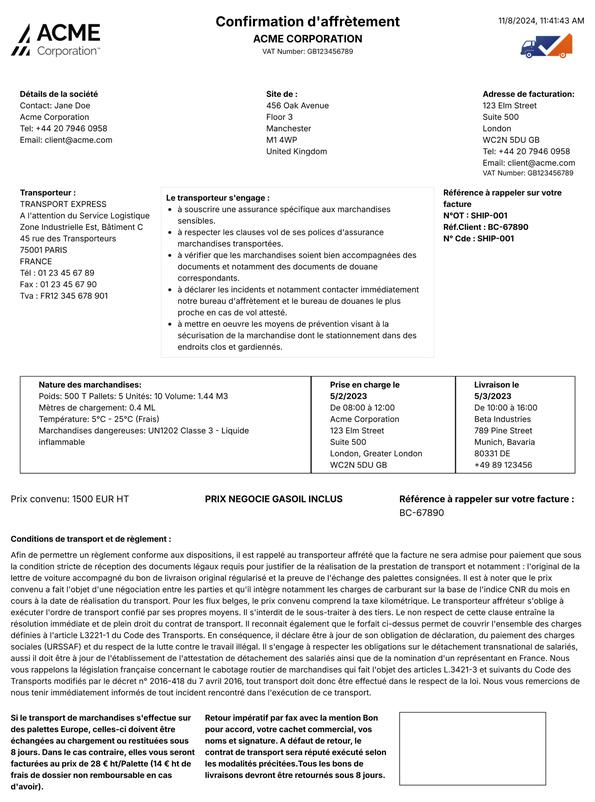

In [5]:
schema_obj.openai_responses_messages + doc_msg.openai_responses_messages

In [6]:
from openai import OpenAI

# Now you can use your favorite model to analyze your document
client = OpenAI()

completion = client.responses.create(
    model="gpt-4o-mini",
    input=schema_obj.openai_responses_messages + doc_msg.openai_responses_messages,
    text={
        "format": {
            "type": "json_schema",
            "name": schema_obj.id,
            "schema": schema_obj.inference_json_schema,
            "strict": True
        }
    }
)
print(completion.output_text)

{"reasoning___root":"Analysis shows:\n- Document type identified as a freight booking confirmation from ACME Corporation.\n- Key parties involved: Client is ACME Corporation (details include contact name, telephone number, and email), and Carrier is Transport Express.\n- Overall structure includes detailed shipment information and sender/recipient addresses.\n- Critical booking details include specific handling conditions for dangerous goods and applicable temperatures for transport.\n- Clear ambiguities regarding additional context on loading and unloading procedures noted.\n\nOverall, the document is well-structured, with all critical information explicitly stated.","booking_id":"BC-67890","payment":{"total_price":1500,"currency":"EUR"},"client":{"company_name":"ACME Corporation","reasoning___VAT_number":"Found VAT number GB123456789 in the header of the document.","VAT_number":"GB123456789","city":"London","postal_code":"WC2N 5DU","country":"GB","code":"ACME001","email":"client@acme

In [ ]:
## This also work with streaming!
from jiter import from_json
from IPython.display import clear_output, display

client = OpenAI()
output_text_cum = ""
with client.responses.stream(
    model="gpt-4o-mini",
    input=schema_obj.openai_responses_messages + doc_msg.openai_responses_messages,
    text={
        "format": {
            "type": "json_schema",
            "name": schema_obj.id,
            "schema": schema_obj.inference_json_schema,
            "strict": True
        }
    } 
) as stream:
    for event in stream:
        if event.type == "response.output_text.delta":
            output_text_cum += event.delta
            clear_output(wait=True)
            # Use this if you want to parse partial json objects.
            display(from_json(bytes(output_text_cum, "utf-8"), partial_mode="trailing-strings"))
        elif event.type == "response.completed":
            clear_output(wait=True)
            # Should be directly a valid json object!
            display(json.loads(event.response.output_text))


{'reasoning___root': 'Analysis shows:\n- Clear booking confirmation document from ACME CORPORATION\n- Single shipment under booking reference BC-67890\n- Client identified as ACME CORPORATION from letterhead\n- Shipping address and billing address provided\n- All required signatures and VAT information is present',
 'booking_id': 'BC-67890',
 'payment': {'total_price': 1500, 'currency': 'EUR'},
 'client': {'company_name': 'ACME CORPORATION',
  'reasoning___VAT_number': 'Found VAT number GB123456789 in header next to company details',
  'VAT_number': 'GB123456789',
  'city': 'London',
  'postal_code': 'WC2N 5DU',
  'country': 'GB',
  'code': None,
  'email': 'client@acme.com'},
 'reasoning___shipments': 'Shipment Analysis:\n1: Dangerous goods - 5 pallets at a weight of 500 kg (UN1202, liquid, Class 3)\n2: Total volume of 1.44 m³\n3: Temperature range of 5°C to 25°C, Fracht considerations to be observed during the transport',
 'shipments': [{'shipment_id': 'SHIP-001',
   'reasoning___sen